In [1]:
import argparse
import cv2
import glob
import os
import torch
import requests
import numpy as np
from os import path as osp
from collections import OrderedDict
from torch.utils.data import DataLoader
import utils.utils_video
import torch.utils.data as data
from torchvision import transforms
from PIL import Image

import utils.utils_video as utils_video

from archs.vrt.network_vrt import VRT as net
from utils import utils_image as util


import sys
import os.path
import math
import argparse
import time
import random
import cv2
import numpy as np
from collections import OrderedDict
import logging
import torch

from utils import utils_image as util
from utils import utils_option as option
from utils.utils_dist import get_dist_info, init_dist

seed = random.randint(1, 10000)

from matplotlib import pyplot as plt

In [2]:
def test_video(lq, model, args):
        '''test the video as a whole or as clips (divided temporally). '''

        num_frame_testing = args.tile[0]
        if num_frame_testing:
            # test as multiple clips if out-of-memory
            sf = args.scale
            num_frame_overlapping = args.tile_overlap[0]
            not_overlap_border = False
            b, d, c, h, w = lq.size()
            c = c - 1 if args.nonblind_denoising else c
            stride = num_frame_testing - num_frame_overlapping
            d_idx_list = list(range(0, d-num_frame_testing, stride)) + [max(0, d-num_frame_testing)]
            E = torch.zeros(b, d, c, h*sf, w*sf)
            W = torch.zeros(b, d, 1, 1, 1)

            for d_idx in d_idx_list:
                lq_clip = lq[:, d_idx:d_idx+num_frame_testing, ...]
                out_clip = test_clip(lq_clip, model, args)
                out_clip_mask = torch.ones((b, min(num_frame_testing, d), 1, 1, 1))

                if not_overlap_border:
                    if d_idx < d_idx_list[-1]:
                        out_clip[:, -num_frame_overlapping//2:, ...] *= 0
                        out_clip_mask[:, -num_frame_overlapping//2:, ...] *= 0
                    if d_idx > d_idx_list[0]:
                        out_clip[:, :num_frame_overlapping//2, ...] *= 0
                        out_clip_mask[:, :num_frame_overlapping//2, ...] *= 0

                E[:, d_idx:d_idx+num_frame_testing, ...].add_(out_clip)
                W[:, d_idx:d_idx+num_frame_testing, ...].add_(out_clip_mask)
            output = E.div_(W)
        else:
            # test as one clip (the whole video) if you have enough memory
            window_size = args.window_size
            d_old = lq.size(1)
            d_pad = (window_size[0] - d_old % window_size[0]) % window_size[0]
            lq = torch.cat([lq, torch.flip(lq[:, -d_pad:, ...], [1])], 1) if d_pad else lq
            output = test_clip(lq, model, args)
            output = output[:, :d_old, :, :, :]

        return output


def test_clip(lq, model, args):
    ''' test the clip as a whole or as patches. '''

    sf = args.scale
    window_size = args.window_size
    size_patch_testing = args.tile[1]
    assert size_patch_testing % window_size[-1] == 0, 'testing patch size should be a multiple of window_size.'

    if size_patch_testing:
        # divide the clip to patches (spatially only, tested patch by patch)
        overlap_size = args.tile_overlap[1]
        not_overlap_border = True

        # test patch by patch
        b, d, c, h, w = lq.size()
        c = c - 1 if args.nonblind_denoising else c
        stride = size_patch_testing - overlap_size
        h_idx_list = list(range(0, h-size_patch_testing, stride)) + [max(0, h-size_patch_testing)]
        w_idx_list = list(range(0, w-size_patch_testing, stride)) + [max(0, w-size_patch_testing)]
        E = torch.zeros(b, d, c, h*sf, w*sf)
        W = torch.zeros_like(E)

        for h_idx in h_idx_list:
            for w_idx in w_idx_list:
                in_patch = lq[..., h_idx:h_idx+size_patch_testing, w_idx:w_idx+size_patch_testing]

                out_patch = model(in_patch).detach().cpu()

                out_patch_mask = torch.ones_like(out_patch)

                if not_overlap_border:
                    if h_idx < h_idx_list[-1]:
                        out_patch[..., -overlap_size//2:, :] *= 0
                        out_patch_mask[..., -overlap_size//2:, :] *= 0
                    if w_idx < w_idx_list[-1]:
                        out_patch[..., :, -overlap_size//2:] *= 0
                        out_patch_mask[..., :, -overlap_size//2:] *= 0
                    if h_idx > h_idx_list[0]:
                        out_patch[..., :overlap_size//2, :] *= 0
                        out_patch_mask[..., :overlap_size//2, :] *= 0
                    if w_idx > w_idx_list[0]:
                        out_patch[..., :, :overlap_size//2] *= 0
                        out_patch_mask[..., :, :overlap_size//2] *= 0

                E[..., h_idx*sf:(h_idx+size_patch_testing)*sf, w_idx*sf:(w_idx+size_patch_testing)*sf].add_(out_patch)
                W[..., h_idx*sf:(h_idx+size_patch_testing)*sf, w_idx*sf:(w_idx+size_patch_testing)*sf].add_(out_patch_mask)
        output = E.div_(W)

    else:
        _, _, _, h_old, w_old = lq.size()
        h_pad = (window_size[1] - h_old % window_size[1]) % window_size[1]
        w_pad = (window_size[2] - w_old % window_size[2]) % window_size[2]

        lq = torch.cat([lq, torch.flip(lq[:, :, :, -h_pad:, :], [3])], 3) if h_pad else lq
        lq = torch.cat([lq, torch.flip(lq[:, :, :, :, -w_pad:], [4])], 4) if w_pad else lq
        print(lq.shape)
        output = model(lq).detach().cpu()

        output = output[:, :, :, :h_old*sf, :w_old*sf]

    return output



In [3]:
model = net(upscale=2, img_size=[6,64,64], window_size=[6,8,8], depths=[8,8,8,8,8,8,8, 4,4,4,4, 4,4],
                    indep_reconsts=[11,12], embed_dims=[120,120,120,120,120,120,120,180,180,180,180, 180,180],
                    num_heads=[6,6,6,6,6,6,6,6,6,6,6,6,6], pa_frames=2, deformable_groups=12)

/home/26e_kas@lab.graphicon.ru/anaconda3/envs/vrt/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
#model_path = f'experiments/001_train_vrt_videosr_bi_vimeo_7frames/models/5000_G.pth'
model_path = f'experiments/002_finetune_vrt_realvsr_7frames/models/10000_G.pth'
if os.path.exists(model_path):
    print(f'loading model from ./model_zoo/vrt/{model_path}')
pretrained_model = torch.load(model_path)
model.load_state_dict(pretrained_model['params'] if 'params' in pretrained_model.keys() else pretrained_model, strict=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model.eval()
model = model.to(device)

loading model from ./model_zoo/vrt/experiments/002_finetune_vrt_realvsr_7frames/models/10000_G.pth


In [21]:
!ls ../mnt/calypso/aaa

000.png  001.png  002.png  003.png  004.png  005.png  006.png


In [22]:
# sudo mount.cifs //calypso/work/26e_kas ~/mnt/calypso -o credentials=$HOME/mnt/credentials,uid=$(id -u),gid=$(id -g)
#lq_path = '../mnt/calypso/datasets/026'
#lq_path = '../mnt/calypso/datasets/realvsr/LQ/505'
lq_path = '../mnt/calypso/aaa'
imgs_lq = utils.utils_video.read_img_seq(lq_path)
#imgs_lq = torch.cat([imgs_lq, imgs_lq[-1:,...]], dim=0)
#imgs_lq = torch.cat([imgs_lq, imgs_lq.flip(0)], dim=0)
imgs_lq = imgs_lq[:7]
imgs_lq.shape

torch.Size([7, 3, 320, 240])

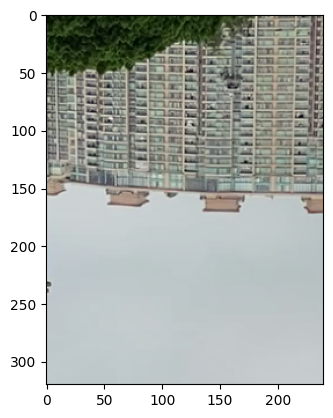

In [23]:
lq = imgs_lq[0].detach().cpu().numpy()
lq = np.moveaxis(lq, 0, 2)
#a = np.moveaxis(a, 1, 0)
plt.imshow(lq)

In [8]:
! ls ../mnt/calypso

025_out  Anaconda3-2022.10-Linux-x86_64.sh  Real-ESRGAN
026_out  artifacts			    SRAD
505	 datasets			    vrt_experiments


In [30]:
class Args():
    def __init__(self, scale=2):
        self.task = lq_path
        self.sigma = 0
        self.tile = [12, 64, 64]
        self.tile_overlap = [0, 20, 20]
        self.num_workers = 16
        self.save_result = True
        self.scale = scale
        self.nonblind_denoising = False
        self.window_size = [6, 8, 8]

In [31]:
args = Args()
with torch.no_grad():
    output = test_video(imgs_lq[None, ...].to(device), model, args)

In [32]:
output.size()

torch.Size([1, 7, 3, 640, 480])

In [33]:
a = output[0, 1].detach().cpu().numpy()
a = np.moveaxis(a, 0, 2)
#a = np.moveaxis(a, 1, 0)
a.shape

(640, 480, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


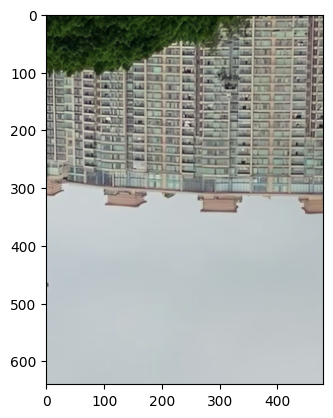

In [34]:
plt.imshow(a)

In [35]:
cv2.imwrite('../mnt/calypso/aaa_out/2x_ft002_10k.png', a[..., ::-1] * 255)
#cv2.imwrite('../mnt/calypso/lq.png', lq[..., ::-1] * 255)

True

In [84]:
from archs.vrt.network_vrt import Upsample
model_2x = model
model_2x.upsample = Upsample(2, 64)
model_2x.to(device)
model_2x.upscale = 2

In [13]:
args_2x = Args(scale=2)
with torch.no_grad():
    output_2x = test_video(imgs_lq[None, ...].to(device), model_2x, args_2x)

In [14]:
output_2x[0, 1].shape

torch.Size([3, 1920, 1080])

In [15]:
b = output_2x[0, 1].detach().cpu().numpy()
b = np.moveaxis(b, 0, 2)
#b = np.moveaxis(b, 1, 0)
b.shape

(1920, 1080, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


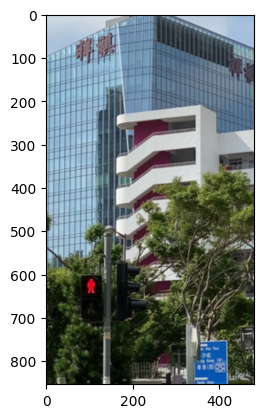

In [16]:

plt.imshow(b)

In [16]:
cv2.imwrite('../mnt/calypso/2x_base.png', b[..., ::-1] * 255)

True

In [10]:
c = cv2.imread('../mnt/calypso/datasets/RealVSR/LQ/505/00006.png')
cv2.imwrite('../mnt/calypso/2x_bicubic.png', cv2.resize(c, (b.shape[1], b.shape[0]), interpolation=cv2.INTER_CUBIC))

NameError: name 'b' is not defined

In [20]:
!ls experiments/001_train_vrt_videosr_bi_vimeo_7frames/models

1200_G.pth	     3000_G.pth		  4500_G.pth
1200_optimizerG.pth  3000_optimizerG.pth  4500_optimizerG.pth
1500_G.pth	     300_G.pth		  4800_G.pth
1500_optimizerG.pth  300_optimizerG.pth   4800_optimizerG.pth
1800_G.pth	     3300_G.pth		  5000_G.pth
1800_optimizerG.pth  3300_optimizerG.pth  5000_optimizerG.pth
2100_G.pth	     3600_G.pth		  600_G.pth
2100_optimizerG.pth  3600_optimizerG.pth  600_optimizerG.pth
2400_G.pth	     3900_G.pth		  900_G.pth
2400_optimizerG.pth  3900_optimizerG.pth  900_optimizerG.pth
2700_G.pth	     4200_G.pth
2700_optimizerG.pth  4200_optimizerG.pth


In [21]:
model_trained = model_2x
model_trained_path = f'experiments/001_train_vrt_videosr_bi_vimeo_7frames/models/5000_G.pth'
trained_model = torch.load(model_trained_path)
model_trained.load_state_dict(trained_model['params'] if 'params' in trained_model.keys() else trained_model, strict=True)
device = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')
model_trained.eval()
model_trained = model_trained.to(device)

In [22]:
args_2x = Args(scale=2)
with torch.no_grad():
    output_2x_trained = test_video(imgs_lq[None, ...].to(device), model_trained, args_2x)

/home/26e_kas@lab.graphicon.ru/anaconda3/envs/vrt/lib/python3.11/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [25]:
d = output_2x_trained[0, 1].detach().cpu().numpy()
d = np.moveaxis(d, 0, 2)
#b = np.moveaxis(b, 1, 0)
d.shape

(1920, 1080, 3)

In [26]:
cv2.imwrite('../mnt/calypso/2x_trained.png', d[..., ::-1] * 255)

True